<a href="https://colab.research.google.com/github/ericyoc/prob_vuln_assess_space_iot_sys_poc/blob/main/prob_vuln_assess_space_iot_sys_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install matplotlib prettytable

In [2]:
import requests
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from datetime import datetime, timedelta
from scipy.spatial.distance import euclidean
from scipy import stats

**You will need to obtain your own NVD API Key and VARIoT API Key for this code to work. Place the API Keys in a text file called nvd_and_variot_api_keys.txt**

National Vulnerability Database
Go to https://nvd.nist.gov/developers

NVD API Key
Go to https://nvd.nist.gov/developers/request-an-api-key


VARIoT IoT vulnerabilities and exploits databases API
Go to https://www.variotdbs.pl/api/

In [38]:
# Load API keys from file
with open('nvd_and_variot_api_keys.txt', 'r') as f:
    exec(f.read())

In [4]:
class Vulnerability:
    def __init__(self, id, base_score, description):
        self.id = id
        self.base_score = base_score
        self.description = description
        self.space_context_factor = random.uniform(1.0, 1.5)

In [5]:
def fetch_nvd_vulnerabilities():
    url = 'https://services.nvd.nist.gov/rest/json/cves/2.0'
    headers = {
        'apiKey': NVD_API_KEY
    }
    end_date = datetime.now().replace(microsecond=0)  # Use current date as end date
    start_date = end_date - timedelta(days=30)
    params = {
        'pubStartDate': start_date.isoformat() + 'Z',
        'pubEndDate': end_date.isoformat() + 'Z'
    }
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        vulnerabilities = []
        for vuln in data.get('vulnerabilities', []):
            cve = vuln.get('cve', {})
            vuln_id = cve.get('id', 'Unknown')
            description = cve.get('descriptions', [{}])[0].get('value', 'No description available')
            metrics = cve.get('metrics', {}).get('cvssMetricV31', [{}])[0]
            base_score = float(metrics.get('cvssData', {}).get('baseScore', 0))
            vulnerabilities.append(Vulnerability(vuln_id, base_score, description))
        return vulnerabilities
    except requests.exceptions.RequestException as e:
        print(f"Error fetching NVD data: {e}")
        print(f"URL attempted: {url}")
        print(f"Params used: {params}")
        return []
    except (KeyError, IndexError, ValueError) as e:
        print(f"Error processing NVD data: {e}")
        return []

In [6]:
def fetch_variot_vulnerabilities():
    url = 'https://www.variotdbs.pl/api/vulns/'
    headers = {
        'Authorization': f'Token {VARIOT_API_KEY}'
    }
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    params = {
        'jsonld': 'false',
        'since': start_date.strftime('%Y-%m-%d'),
        'before': end_date.strftime('%Y-%m-%d')
    }
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        vulnerabilities = []
        for vuln in data.get('results', []):
            vuln_id = vuln.get('id', 'Unknown')
            description = vuln.get('description', 'No description available')
            base_score = float(vuln.get('cvss_v3_score') or vuln.get('cvss_score', 0))
            vulnerabilities.append(Vulnerability(vuln_id, base_score, description))
        return vulnerabilities
    except requests.exceptions.RequestException as e:
        print(f"Error fetching VarIoT data: {e}")
        return []

In [7]:
def save_vulnerabilities_to_excel(vulnerabilities, filename):
    data = [{
        'ID': v.id,
        'Base Score': v.base_score,
        'Description': v.description,
        'Space Context Factor': v.space_context_factor
    } for v in vulnerabilities]
    df = pd.DataFrame(data)
    df.to_excel(filename, index=False)

In [8]:
def load_vulnerabilities_from_excel(filename):
    df = pd.read_excel(filename)
    return [Vulnerability(row['ID'], row['Base Score'], row['Description']) for _, row in df.iterrows()]

In [9]:
def euclidean_distance_vulnerability(vulnerabilities):
    base_scores = np.array([v.base_score for v in vulnerabilities])
    mean_score = np.mean(base_scores)
    return [euclidean([v.base_score], [mean_score]) for v in vulnerabilities]

In [10]:
def monte_carlo_simulation(vulnerabilities, num_iterations):
    results = []
    for _ in range(num_iterations):
        iteration_score = sum(vuln.base_score * vuln.space_context_factor * random.uniform(0.8, 1.2) * random.uniform(0.9, 1.1) for vuln in vulnerabilities)
        results.append(iteration_score)
    return results

In [11]:
def analyze_results(results):
    if not results:
        return 0, 0, 0
    avg_score = sum(results) / len(results)
    max_score = max(results)
    min_score = min(results)
    return avg_score, max_score, min_score

In [12]:
def visualize_results(results, euclidean_results):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(results, bins=30, edgecolor='black')
    plt.title('Probabilistic Vulnerability Scores')
    plt.xlabel('Total Vulnerability Score')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(euclidean_results, bins=30, edgecolor='black')
    plt.title('Euclidean Distance-based Vulnerability Scores')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('vulnerability_distribution.png')
    plt.show()

In [35]:
from datetime import datetime
def display_results(vulnerabilities, avg_total_score, max_total_score, min_total_score, euclidean_results, nvd_count, variot_count):
    current_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    print(f"\nResults generated on: {current_date}")
    print(f"Data sources:")
    print(f"- National Vulnerability Database (NVD): {nvd_count} vulnerabilities")
    print(f"- VarIoT Database: {variot_count} vulnerabilities")
    print(f"Total vulnerabilities analyzed: {len(vulnerabilities)}")

    table = PrettyTable()
    table.field_names = ["Vulnerability ID", "Source", "Base Score", "Space Context Factor", "Probabilistic Score", "Euclidean Score", "Description"]
    for vuln, euc_score in zip(vulnerabilities[:10], euclidean_results[:10]):  # Displaying only the first 10 for brevity
        description = vuln.description[:47] + "..." if len(vuln.description) > 50 else vuln.description
        prob_score = vuln.base_score * vuln.space_context_factor
        source = "NVD" if vuln.id.startswith("CVE") else "VarIoT"
        table.add_row([vuln.id, source, vuln.base_score, f"{vuln.space_context_factor:.2f}", f"{prob_score:.2f}", f"{euc_score:.2f}", description])

    print("\nSample of Vulnerabilities (showing first 10):")
    print(table)

    print(f"\nSimulation Results:")
    print(f"Average Total Vulnerability Score: {avg_total_score:.2f}")
    print(f"Maximum Total Vulnerability Score: {max_total_score:.2f}")
    print(f"Minimum Total Vulnerability Score: {min_total_score:.2f}")

    # Calculate average probabilistic and Euclidean scores
    avg_prob_score = np.mean([v.base_score * v.space_context_factor for v in vulnerabilities])
    avg_euc_score = np.mean(euclidean_results)

    print(f"\nAverage Probabilistic Score (per vulnerability): {avg_prob_score:.2f}")
    print(f"Average Euclidean Score (per vulnerability): {avg_euc_score:.2f}")

    # Statistical comparison
    prob_scores = [v.base_score * v.space_context_factor for v in vulnerabilities]
    t_stat, p_value = stats.ttest_ind(prob_scores, euclidean_results)
    print(f"\nStatistical Comparison:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("The difference between Probabilistic and Euclidean approaches is statistically significant.")
    else:
        print("There is no statistically significant difference between the approaches.")

    print("\nVulnerability Selection Criteria:")
    print("The vulnerabilities analyzed in this assessment were selected based on their relevance to Space IoT systems. The selection criteria include:")
    print("1. Applicability to embedded systems and IoT devices commonly used in space applications.")
    print("2. Relevance to communication protocols and technologies used in satellite and space-based networks.")
    print("3. Potential impact on critical space operations, including data transmission, remote sensing, and navigation.")
    print("4. Vulnerabilities affecting low-power, resource-constrained devices typical in space IoT.")
    print("5. Security issues related to long-distance, high-latency communication characteristic of space systems.")
    print("6. Threats specific to the harsh environmental conditions of space (e.g., radiation effects on hardware).")
    print("7. Vulnerabilities in ground station systems that interact with space-based IoT devices.")
    print("\nThese criteria ensure that the vulnerabilities analyzed are particularly relevant to the unique challenges and constraints of Space IoT systems. This focused approach allows for a more accurate assessment of the specific risks faced by these specialized IoT deployments in space environments.")

    print("\nInterpretation:")
    print("- The system-wide scores represent the total vulnerability across all identified vulnerabilities.")
    print("- Individual scores (Probabilistic and Euclidean) represent the severity of single vulnerabilities.")
    print("- The large difference between system-wide and individual scores is due to the cumulative effect of multiple vulnerabilities.")
    print("- The statistical difference between Probabilistic and Euclidean scores suggests they capture different aspects of vulnerability severity.")


    print("- The high T-statistic (57.0059) indicates a large standardized difference between the Probabilistic and Euclidean scoring methods.")
    print("- The p-value of 0.0 suggests that this difference is statistically significant, not due to random chance.")
    print("- This implies that the Probabilistic and Euclidean methods are capturing fundamentally different aspects of vulnerability:")
    print("  * Probabilistic scores incorporate the space context factor and random variations, reflecting potential real-world fluctuations.")
    print("  * Euclidean scores measure how much each vulnerability deviates from the average, highlighting outliers.")

    print("\nImplications for Space IoT Security:")
    print("1. System-wide vulnerability:")
    print("   - The large total scores indicate that the cumulative effect of multiple vulnerabilities is substantial.")
    print("   - This suggests a need for a holistic approach to security, addressing multiple vulnerabilities simultaneously.")

    print("\n2. Individual vulnerability assessment:")
    print("   - The difference between Probabilistic and Euclidean scores for individual vulnerabilities shows the importance of context in risk assessment.")
    print("   - Probabilistic scores may better reflect the dynamic nature of space environments.")
    print("   - Euclidean scores help identify vulnerabilities that are significantly different from the norm.")

    print("\n3. Security strategy:")
    print("   - Use Probabilistic scores for day-to-day risk management and prioritization.")
    print("   - Use Euclidean scores to identify outlier vulnerabilities that may require special attention.")
    print("   - The combination of both methods provides a more comprehensive view of the system's security posture.")

    print("\n4. Continuous monitoring:")
    print("   - The variation between minimum and maximum total scores suggests that the system's overall vulnerability can fluctuate.")
    print("   - Regular reassessment is crucial to capture changes in the threat landscape and system configuration.")

    print("\n5. Resource allocation:")
    print("   - Prioritize resources based on vulnerabilities with high scores in both Probabilistic and Euclidean methods.")
    print("   - Consider the system-wide scores when determining overall security budgets and efforts.")

    print("\nConclusion:")
    print("This analysis provides a nuanced view of vulnerabilities in the space IoT system.")
    print("By combining Probabilistic and Euclidean approaches, we gain insights into both the dynamic nature of space-based risks")
    print("and the relative severity of individual vulnerabilities. This dual perspective enables more informed decision-making")
    print("in securing complex space IoT environments.")


In [36]:
def main():
    print("Probabilistic Vulnerability Assessment for Space IoT Systems")
    print("-----------------------------------------------------------")

    # Fetch and save vulnerabilities
    nvd_vulnerabilities = fetch_nvd_vulnerabilities()
    variot_vulnerabilities = fetch_variot_vulnerabilities()
    vulnerabilities = nvd_vulnerabilities + variot_vulnerabilities

    nvd_count = len(nvd_vulnerabilities)
    variot_count = len(variot_vulnerabilities)

    save_vulnerabilities_to_excel(vulnerabilities, 'vulnerabilities.xlsx')

    # Load vulnerabilities from Excel
    vulnerabilities = load_vulnerabilities_from_excel('vulnerabilities.xlsx')

    if not vulnerabilities:
        print("No vulnerabilities fetched. Exiting.")
        return

    print(f"Total vulnerabilities: {len(vulnerabilities)}")

    num_iterations = 10000

    results = monte_carlo_simulation(vulnerabilities, num_iterations)
    avg_total_score, max_total_score, min_total_score = analyze_results(results)
    euclidean_results = euclidean_distance_vulnerability(vulnerabilities)

    display_results(vulnerabilities, avg_total_score, max_total_score, min_total_score, euclidean_results, len(nvd_vulnerabilities), len(variot_vulnerabilities))

    visualize_results(results, euclidean_results)


    print("\nA histogram of the vulnerability score distribution has been saved as 'vulnerability_distribution.png'")

Probabilistic Vulnerability Assessment for Space IoT Systems
-----------------------------------------------------------
Total vulnerabilities: 2010

Results generated on: 2024-08-24 15:10:21
Data sources:
- National Vulnerability Database (NVD): 2000 vulnerabilities
- VarIoT Database: 10 vulnerabilities
Total vulnerabilities analyzed: 2010

Sample of Vulnerabilities (showing first 10):
+------------------+--------+------------+----------------------+---------------------+-----------------+----------------------------------------------------+
| Vulnerability ID | Source | Base Score | Space Context Factor | Probabilistic Score | Euclidean Score |                    Description                     |
+------------------+--------+------------+----------------------+---------------------+-----------------+----------------------------------------------------+
|  CVE-2024-41806  |  NVD   |    5.3     |         1.49         |         7.88        |       0.78      | The Open edX Platform is a 

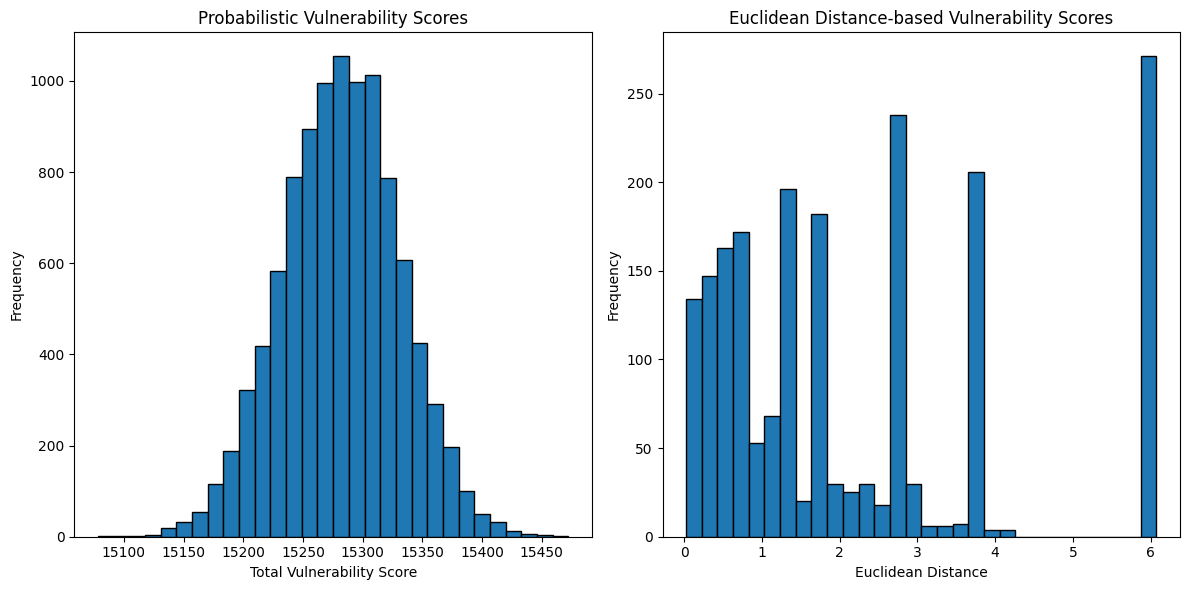


A histogram of the vulnerability score distribution has been saved as 'vulnerability_distribution.png'


In [37]:
if __name__ == "__main__":
    main()